In [1]:
# import statements

import matplotlib.pyplot as plt
from __future__ import division
import os, sys, random
import numpy as np

# function to draw the table for Values and greedy policy
from utilities import *

is_latex_output_needed = False # make it true to get latex table outputs

<img src='./maze.png' width=400 align='left'/>

In [2]:
# check if the state, we end up after taking an action is a valid state
# especially to check the corner cases
def get_valid_state(prev_state, curr_state):
    # check the validity of the current state
    if((curr_state[0] >= 0 and curr_state[0] < 10) and
       (curr_state[1] >= 0 and curr_state[1] < 10)):
        
        # if the next state is valid, return the state         
        return curr_state
    else:
        return prev_state
        

In [3]:
# function to get the next state after performing the action
def get_state(current_state, action):
    next_state = None
    
    if action == 'UP':
        next_state = get_valid_state(current_state, 
                                     (current_state[0] - 1, current_state[1]))
    elif action == 'DOWN':
        next_state = get_valid_state(current_state,
                                     (current_state[0] + 1, current_state[1]))
    elif action == 'LEFT':
        next_state = get_valid_state(current_state,
                                     (current_state[0], current_state[1] - 1))
    else: # RIGHT
        next_state = get_valid_state(current_state,
                                     (current_state[0], current_state[1] + 1))
    
    return next_state

In [4]:
# get the other uncertain actions (with probability 0.1) associated
# with an action
def get_uncertain_actions(action):
    if action == 'UP' or action == 'DOWN':
        return ['LEFT', 'RIGHT']
    else:
        return ['UP', 'DOWN']

In [5]:
# get the next state after taking an action
def get_transition_states(current_state, action):
    transitions = []
    
    # handle the grey IN states (transition is independent of action)
    if current_state in [(3, 2), (4, 2), (5, 2), (6, 2)]:
        transitions.append([1, (9, 0)])
    
    # handle the brown IN states (transition is independent of action)
    elif current_state in [(8, 7)]:
        transitions.append([1, (0, 7)])
    
    elif current_state == GOAL:
        # do nothing, stay in same state
        pass
    
    else:
        # handle actual states and actions
        transitions.append([0.8, get_state(current_state, action)])
        
        uncertain_actions = get_uncertain_actions(action)
        for uncert_action in uncertain_actions:
            transitions.append([0.1, get_state(current_state, uncert_action)])
    
    return transitions

In [6]:
# to get all the states of the grid for value iteration
def states_enumeration(is_random=True):
    x, y = np.meshgrid(np.arange(10), np.arange(10))
    states = list(zip(x.reshape(-1), y.reshape(-1)))
    
    if is_random:
        random.shuffle(states)
    
    return states

In [7]:
# function to return immediate reward
def get_immediate_reward(state):
    if state == GOAL:
        return +100
    else:
        return -1
    

In [8]:
# calculation of value for a particular state and action by having the 
# previous value table in mind
def get_value(state, action, V):
    transitions = get_transition_states(state, action)
    
    current_value = 0
    
    # for each transition from the state, calculate expected return
    for transition in transitions:
        probability = transition[0]
        target_state = transition[1]        
        current_value += (probability * (get_immediate_reward(target_state)
                                         + V[target_state]))
    
    return current_value
    

In [9]:
# function to perform value iteration
def value_iteration(GOAL):
    V_trace = []
    policy_trace = []

    max_costs = []
    N = 10

    # initialize value of all states
    V = np.zeros((N, N))
    actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    pi = np.chararray(V.shape)
    eps = 1e-10

    is_stop = False
    
    # loop for value iteration
    while not is_stop:
        prev_V = V.copy()
        V = np.zeros((N, N))
        
        # get all the states for performing VI
        states = states_enumeration()

        for state in states:
            # do not update value for GOAL state
            if state == GOAL:
                continue

            current_values = []
            
            # for each action in a state, get the values
            for action in actions:
                current_values.append(get_value(state, action, prev_V))

            # find the max value and greedy policy
            V[state] = max(current_values)
            pi[state] = actions[np.argmax(current_values)][0]

        # check for stopping condition
        max_error = np.max(np.abs(prev_V - V))
        max_costs.append(max_error)
        
        # note down the V,pi after 10, 25 iterations
        if len(max_costs) in [10, 25]:
            V_trace.append(V.copy())
            policy_trace.append(pi.copy())
            
        if max_error <= eps:
            is_stop = True

    print('In total, ', len(max_costs), ' iterations')
    # V,pi after VI is stopped
    V_trace.append(V.copy())
    policy_trace.append(pi.copy())
    return V, pi, max_costs, V_trace, policy_trace

In [10]:
def plot_graph(max_costs, filename):
    # function to plot line graph
    plt.plot(range(len(max_costs)), max_costs)
    plt.xlabel('iterations')
    plt.ylabel('difference between consecutive max values')
    plt.title('iterations vs value difference')
    plt.savefig(filename)    

('In total, ', 67, ' iterations')
   0  1  2  3  4  5  6  7  8  9
0  R  R  R  R  R  R  R  R  R  �
1  R  R  R  R  R  R  R  R  U  U
2  U  R  U  R  R  R  R  U  U  U
3  U  U  U  R  R  R  R  U  U  U
4  U  U  U  R  R  R  R  R  U  U
5  D  R  U  R  R  R  D  D  U  U
6  D  D  U  R  R  R  D  D  D  U
7  R  R  R  R  R  R  D  D  D  L
8  R  R  R  R  R  R  R  U  L  L
9  R  R  R  R  R  R  R  U  L  L


        0       1       2       3       4       5       6       7       8  \
0  88.723  90.060  91.402  92.748  94.099  95.457  96.825  98.203  99.594   
1  88.025  89.326  90.634  91.942  93.232  94.519  95.801  97.076  98.342   
2  86.925  88.124  89.401  90.816  92.070  93.323  94.575  95.826  97.076   
3  85.790  86.708  86.294  89.663  90.884  92.108  93.338  94.575  95.801   
4  84.642  85.460  86.294  88.745  89.902  91.056  92.208  93.359  94.523   
5  84.219  85.218  86.294  88.569  89.687  90.787  91.865  92.840  93.313   
6  85.344  86.369  86.294  89.448  90.669  91.895  93.128  94.152  93.239

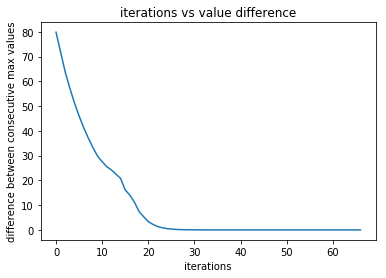

In [11]:
# Q2.1
# perform value iteration and display greedy policy and value table
GOAL = (0, 9) # (3, 0)
V, pi, max_costs, V_trace, pi_trace = value_iteration(GOAL)
display_table(pi, is_latex_output_needed)
display_table(np.around(V, decimals=3), is_latex_output_needed)
plot_graph(max_costs, 'goal1.png')

In [12]:
# show the V values and policy after 10, 25, end of iterations
for i, (_v, _pi) in enumerate(zip(V_trace, pi_trace)):
    display_table(np.around(_v, decimals=3), is_latex_output_needed)
    display_table(pi, is_latex_output_needed)

        0       1       2       3       4       5       6       7       8  \
0  15.891  44.016  62.157  79.675  87.545  93.277  95.970  98.004  99.548   
1  13.045  24.836  57.150  68.072  84.209  89.186  94.236  96.357  98.179   
2 -10.000  18.976  27.795  60.511  69.198  84.860  89.437  94.294  96.357   
3 -10.000 -10.000 -10.000  28.371  60.989  70.631  84.955  89.530  94.236   
4 -10.000 -10.000 -10.000  20.803  37.731  62.474  73.794  84.920  89.411   
5 -10.000 -10.000 -10.000  17.059  32.730  58.330  68.246  79.905  84.550   
6 -10.000 -10.000 -10.000  26.198  56.655  67.517  82.594  86.576  83.714   
7 -10.000  13.723  23.315  55.083  66.679  82.637  88.477  93.482  88.760   
8   3.556  10.502  43.838  59.479  79.225  87.221  93.633  96.765  93.642   
9 -10.000  13.723  34.965  61.018  75.106  85.595  90.353  93.793  90.355   

        9  
0   0.000  
1  99.548  
2  98.004  
3  95.972  
4  93.279  
5  87.818  
6  81.228  
7  83.766  
8  87.506  
9  85.607  


   0  1  2  3  4  

('In total, ', 67, ' iterations')
   0  1  2  3  4  5  6  7  8  9
0  D  D  D  D  L  L  L  L  L  L
1  D  D  D  D  D  L  L  L  L  L
2  D  D  D  D  L  L  L  L  L  L
3  R  R  U  L  L  L  L  L  L  L
4  R  R  U  L  L  L  L  L  L  L
5  R  R  U  D  D  D  L  L  L  L
6  D  R  U  D  D  D  L  L  L  L
7  D  D  D  D  D  D  L  L  L  L
8  R  R  D  D  D  L  L  U  D  D
9  R  R  R  .  L  L  L  L  L  L


        0       1       2       3       4       5       6       7       8  \
0  89.717  90.631  91.372  90.593  89.489  88.372  87.242  86.103  84.955   
1  90.852  91.903  92.812  91.884  90.660  89.430  88.207  86.988  85.772   
2  91.971  93.171  94.292  93.170  91.911  90.648  89.384  88.122  86.863   
3  93.071  94.431  95.822  94.438  93.087  91.761  90.454  89.161  87.878   
4  93.290  94.559  95.822  94.628  93.456  92.270  91.069  89.855  88.632   
5  93.354  94.584  95.822  95.260  94.448  93.293  92.072  90.839  89.598   
6  93.583  94.699  95.822  96.541  95.741  94.552  93.304  91.962  90.633

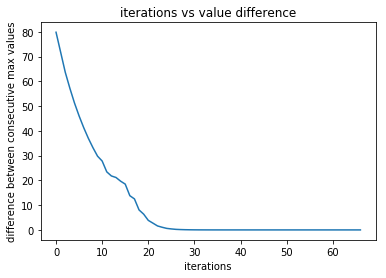

In [13]:
# GOAL 2
GOAL = (9, 3)
# perform value iteration and display greedy policy and value table
V, pi, max_costs, V_trace, pi_trace = value_iteration(GOAL)
display_table(pi, is_latex_output_needed)
display_table(np.around(V, decimals=3), is_latex_output_needed)
plot_graph(max_costs, 'goal2.png')


In [14]:
# show the V values and policy after 10, 25, end of iterations
for i, (_v, _pi) in enumerate(zip(V_trace, pi_trace)):
    display_table(_pi, is_latex_output_needed)
    display_table(np.around(_v, decimals=3), is_latex_output_needed)

   0  1  2  3  4  5  6  7  8  9
0  D  D  D  D  L  D  U  U  U  U
1  D  D  D  D  D  L  L  U  U  U
2  D  D  D  D  L  L  L  L  U  U
3  R  R  U  L  L  L  L  L  L  U
4  R  R  U  L  L  L  L  L  L  U
5  R  R  U  D  D  D  L  L  L  L
6  D  R  U  D  D  D  L  L  L  D
7  D  D  D  D  D  D  L  L  L  L
8  R  R  D  D  D  L  L  U  D  D
9  R  R  R  .  L  L  L  L  L  L


        0       1       2       3       4       5       6       7       8  \
0  33.800  54.360  59.901  54.389  29.286  14.067 -10.000 -10.000 -10.000   
1  57.935  69.377  79.490  68.973  55.677  28.046  13.935 -10.000 -10.000   
2  71.730  83.352  88.425  83.338  69.571  55.395  27.756  12.028 -10.000   
3  82.675  89.794  94.507  89.841  82.759  68.464  51.047  25.464   3.556   
4  85.145  91.061  94.507  91.148  86.297  75.900  62.608  36.618  20.775   
5  86.113  91.274  94.507  92.870  88.639  84.692  69.561  60.786  27.827   
6  87.600  91.604  94.507  95.251  94.066  89.116  84.755  67.940  59.309   
7  91.449  94.378  96.303  97.